In [1]:
import numpy as np
from ian.ian import *
from ian.dset_utils import *
from ian.embed_utils import *
from ian.utils import *
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.rcParams['figure.figsize']  = (6.0, 4.0)
plt.rcParams['figure.dpi'] = 72.0

### Load dataset

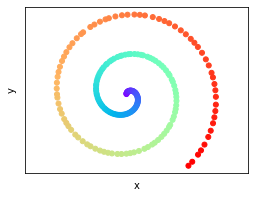

In [2]:
dset = dset_gridspiral()
data_cmap = 'rainbow'

X = dset['X']
c = dset['c']
N = X.shape[0]

_ = plot2dScatter(X, c, s=25, cmap=data_cmap)

In [ ]:
D2 = pwdists(X, sqdists=True) #square matrix of squared Euclidean distances
G, wG, optScales, disc_pts = IAN('exact-precomputed-sq', D2, Xplot=X, plot_interval=2)

### Visualizing resulting scales and data graphs

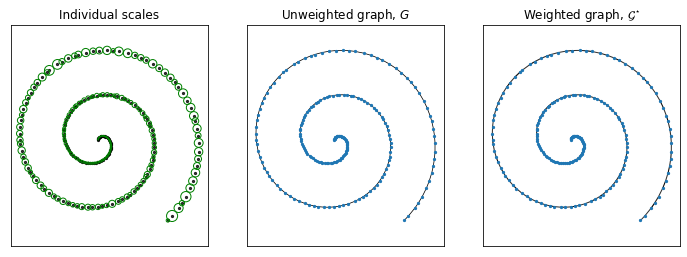

In [4]:
f,axes = subps(1,3,4,4)

### INDIVIDUAL SCALES
ax = axes[0]
ax.set_title('Individual scales')

lvl = .75 #level set of Gaussian kernel to plot

# use kernel formula and solve for the distance, d (radius) using the optimal individual scale, s: 
# lvl = exp(-d^2/(s^2)) --> sˆ2 log(1/lvl) = d^2 --> d = s sqrt(log(1/lvl))

scales_radii = optScales*np.sqrt(np.log(1/lvl))

plotScales(X, [], scales_radii, scalesScl=1, f_axes=(f,[ax]), circleColor='g')

### UNWEIGHTED GRAPH

ax = axes[1]
ax.set_title('Unweighted graph, $G$')

plotDataGraph(X, G, f_ax=(f,ax), edge_color='k', edge_width=.75)


### WEIGHTED GRAPH

ax = axes[2]
ax.set_title('Weighted graph, $\mathcal{G}^{\star}$')
#normalize weights for better visualization and comparison with other methods
#divide by kernel value when the scale equals the distance
#exp( -d^2 / s^2 ) = exp(-1) when d == s
wAdj = wG.toarray()
wAdj /= np.exp(-1)
wAdj[wAdj > 1] = 1 #cant have opacity larger than 1
plotWeightedGraph(X, wAdj, rgb=(0,0,0), f_ax=(f,ax))

plt.show()

### Local dimensionality

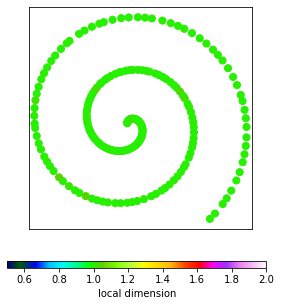

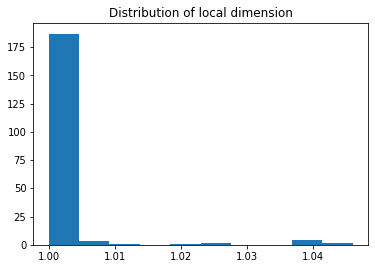

In [5]:
#run NCD algorithm to estimate local dimension
nbrhoodOrder = 2 #using neighbors-of-neighbors up to 2 hops away
NofNDims, degDims = estimateLocalDims(G, D2, nbrhoodOrder) 
dims = np.maximum(degDims,NofNDims)


#set bounds for colormap
MIND, MAXD = min(.5,dims.min()),  max(dims.max(),2.)
norm = matplotlib.colors.Normalize(vmin=MIND, vmax=MAXD)
dim_cmap = matplotlib.cm.get_cmap('gist_ncar')

dimColors = [dim_cmap(norm(si)) for si in dims]

f,ax = subps(1,1,4,4)

plot2dScatter(X,dimColors,f_ax=(f,ax),axLabels=False,s=50)

ax = f.add_axes([0.05, -.025, 0.9, 0.025])
import matplotlib as mpl

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=dim_cmap,
                               norm=mpl.colors.Normalize(MIND, MAXD),
                               label='local dimension')

plt.show()

ax = plt.subplot(111)
ax.hist(dims)
ax.set_title('Distribution of local dimension')
plt.show()

### Heat geodesics

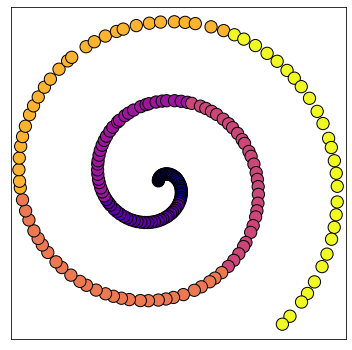

In [6]:
geocenter = [199] #index of starting node(s) for heat diffusion

K = wG.toarray() #convert weighted graph to dense array

#remove any self-weights
np.fill_diagonal(K,0)

t = 100 #heat diffusion time
phis = computeHeatGeodesics(K, t, geocenter)


f,ax = subps(1,1,6,6)

zorder = phis.argsort()[::-1]#put hottest pts on top for clearer visualization
plot2dScatter(X[zorder], phis[zorder], f_ax=(f,ax), axLabels=False, cmap=plasma7r_cmp, s=150, edgecolors=(0,0,0))
plt.show()

### Compare embeddings using different algorithms

In [7]:
D1 = np.sqrt(D2) # (non-sq) distances
n_components = 2 #2-d embedding
rs = 10 #random state

#### Isomap, Diffusion map

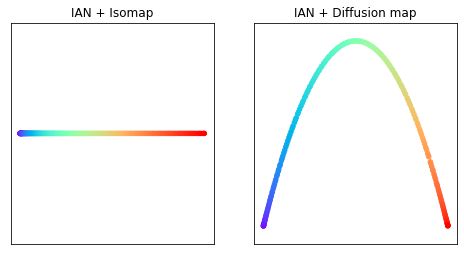

In [8]:


f,axes = subps(1,2,4,4)

### IAN + ISOMAP
ax = axes[0] 
ax.set_title('IAN + Isomap')

dwG = G.multiply(D1) # elementwise multiply to get discrete graph using distances as weights
_, isomap_y = computeIsomap(X, None, n_components, knbrs_graph=dwG)
plot2dScatter(isomap_y, c, cmap=data_cmap, f_ax=(f,ax), s=20, axLabels=False)


### IAN + Diffusion Maps
ax = axes[1]
ax.set_title('IAN + Diffusion map')
alpha = 1
t = 1
diffmap_y, _ = diffusionMapFromK(wG, n_components, alpha, t)
plot2dScatter(diffmap_y, c, cmap=data_cmap, f_ax=(f,ax), s=20, axLabels=False)

plt.show()

#### t-SNE

(note: the t-SNE implementation used here is included in the scikit-learn package)

2 4 8 16 32 

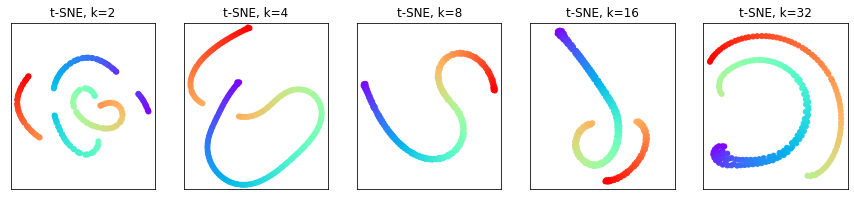

In [9]:
#### t-SNE
perplexities = [2, 4, 8, 16, 32]

f,axes = subps(1,len(perplexities),3,3,axlist=True)

for ax, knn in zip(axes, perplexities):
    print(knn, end=' ')
    #Copute spectral initialization, for better comparison with umap
    
    # (need to compute a kernel matrix first, using t-SNE's own sigmas) 
    sigmas = computeTSNEsigmas(D2, knn) #use knn as perplexity
    myK = computeTSNEkernel(D2, sigmas, False) #no need to normalize b/c will be done by eigenmaps
    init = spectral_init_from_umap(myK, n_components)

    # 2 - compute t-SNE embedding using the init above
    tsne = TSNE(n_components=n_components, learning_rate='auto', metric='precomputed',
               init=init, perplexity=knn, random_state=rs, method="exact")
    tsne_y = tsne.fit_transform(D1.copy())

    plot2dScatter(tsne_y, c, cmap=data_cmap, f_ax=(f,ax), s=25, axLabels=False)
    ax.set_title(f't-SNE, k={knn}')
    
plt.show()

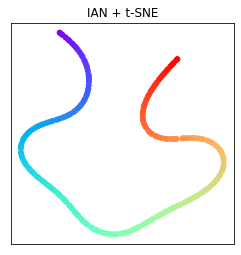

In [10]:
### IAN + t-SNE
from sklearn.manifold import TSNE
%matplotlib inline


# 1 - use same initialization method used by umap (spectral embedding, i.e. Laplacian eigenmaps)
from sklearn.manifold import SpectralEmbedding
spec = SpectralEmbedding(n_components=n_components,affinity='precomputed',random_state=rs)
myK = computeTSNEkernel(D2, optScales, False) #no need to normalize b/c will be done by eigenmaps
init = spec.fit_transform(myK)

# 2 - compute t-SNE embedding with the init above
tsne = TSNE(n_components=n_components, learning_rate='auto',metric='precomputed',
               init=init,random_state=rs, method="exact")
iantsne_y = my_tsne_fit_transform(tsne, D2, optScales, True)

f,ax = subps(1,1,4,4)
ax.set_title('IAN + t-SNE')
plot2dScatter(iantsne_y, c, cmap=data_cmap, f_ax=(f,ax), axisEqual=False, s=25, axLabels=False)
plt.show()

#### UMAP

(note: UMAP is not a pre-requisite for the IAN package; you will need to install it independently in order to run the code below)

2 4 8 16 32 

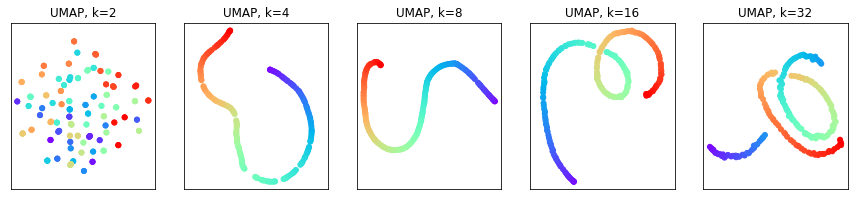

In [11]:
import umap #tested using umap-learn v0.5.3

knns = [2, 4, 8, 16, 32]

f,axes = subps(1,len(knns),3,3,axlist=True)

for ax, knn in zip(axes, knns):
    print(knn, end=' ')
    fit = umap.UMAP(
        n_neighbors=knn,
        n_components=n_components,
        random_state=rs,
    )
    umap_y = fit.fit_transform(X)

    plot2dScatter(umap_y, c, cmap=data_cmap, f_ax=(f,ax), s=25, axLabels=False)
    ax.set_title(f'UMAP, k={knn}')
    
plt.show()

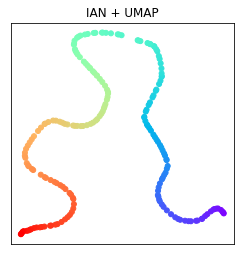

In [12]:
### IAN + UMAP

#setting up a umap object
u = umap.UMAP(
    n_neighbors=X.shape[0]-1, #all points
    n_components=n_components,
    transform_mode="graph", #this option tells umap not to compute the embedding just yet
    random_state=rs,
)
u.fit(X)

#run algorithm with our own weighted graph
myK = wG.toarray()
np.fill_diagonal(myK,0) #remove self-weights (not used by umap)
sparseK = sp.sparse.coo_matrix(myK) #convert into sparse COO format, required by umap


#now run umap's embedding algorithm directly, using the IAN weighted graph
from sklearn.utils import check_random_state, check_array
X_ = check_array(X.copy(), dtype=np.float32, accept_sparse="csr", order="C")

from umap.umap_ import simplicial_set_embedding
ianumap_y,_ = simplicial_set_embedding(X_, sparseK, #just pass along all internal attributes from the umap object create above
            u.n_components, u._initial_alpha, u._a, u._b, u.repulsion_strength, u.negative_sample_rate,
            u.n_epochs, u.init, check_random_state(u.random_state), u._input_distance_func, u._metric_kwds,
            u.densmap, u._densmap_kwds, u.output_dens, u._output_distance_func, u._output_metric_kwds,
            u.output_metric in ("euclidean", "l2"), check_random_state(u.random_state) is None, u.verbose, u.tqdm_kwds)


f,ax = subps(1,1,4,4)
ax.set_title('IAN + UMAP')
plot2dScatter(ianumap_y, c, cmap=data_cmap, f_ax=(f,ax), axisEqual=False, s=25, axLabels=False)
plt.show()